In [1]:
import onnxruntime as ort
ort.get_device()

'GPU'

In [55]:
import onnx
import numpy
from skl2onnx.helpers import collect_intermediate_steps, compare_objects
import timeit
import onnxruntime as rt
from onnxconverter_common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, __version__
import numpy as np
import pandas as pd

from sklearn import datasets, __version__ as skl_version
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

logistic = LogisticRegression()
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

digits = datasets.load_digits()
X_digits = digits.data[:1000]
y_digits = digits.target[:1000]

pipe.fit(X_digits, y_digits)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

### CPU Execution env

In [30]:
initial_types = [('input', FloatTensorType((None, X_digits.shape[1])))]
model_onnx = convert_sklearn(pipe, initial_types=initial_types,
                             target_opset=12)

sess = rt.InferenceSession(model_onnx.SerializeToString(), providers=['CPUExecutionProvider'])
print("skl predict_proba")
print(pipe.predict_proba(X_digits[:1]))
onx_pred = sess.run(None, {'input': X_digits[:1].astype(np.float32)})[1]
df = pd.DataFrame(onx_pred)
print("onnx predict_proba")
print(df.values)

skl predict_proba
[[9.60391089e-01 2.32822583e-07 7.32337678e-04 1.46696345e-02
  5.59314384e-03 5.01685254e-04 7.49111880e-04 3.26559561e-03
  2.91410795e-04 1.38057590e-02]]
onnx predict_proba
[[9.60390985e-01 2.00624967e-07 7.32338463e-04 1.46696689e-02
  5.59310894e-03 5.01677045e-04 7.49133644e-04 3.26562976e-03
  2.91422097e-04 1.38057200e-02]]


In [4]:
compare_objects(pipe.predict_proba(X_digits[:2]), onx_pred)
# No exception so they are the same.

In [31]:
print("scikit-learn")
print(timeit("pipe.predict_proba(X_digits[:1])",
             number=10000, globals=globals()))
print("onnxruntime")
print(timeit("sess.run(None, {'input': X_digits[:1].astype(np.float32)})",
             number=10000, globals=globals()))

scikit-learn
0.8962942810030654
onnxruntime
0.14418294301140122


### Multi core

In [7]:
from joblib import Parallel

In [ ]:
print("scikit-learn")
print(timeit("Parallel(n_jobs=1)(pipe.predict_proba(X_digits[:1]))",
             number=10000, globals=globals()))

In [23]:

X_digits_test = digits.data[1000:]
y_digits_test = digits.target[1000:]


(797,)


In [25]:
print(X_digits[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


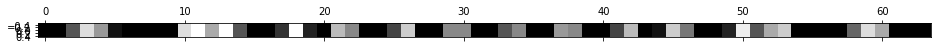

In [20]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.gray() 
plt.matshow(X_digits[:1]) 
plt.show() 

In [67]:
def run():
    for i in range(10000):
        #sess.run(None, {'input': i.reshape(1,64).astype(np.float32)})
        pipe.predict_proba(X_digits[:1])


In [75]:
import timeit
starttime = timeit.default_timer()
#run()
pipe.fit(X_digits, y_digits)
print(timeit.default_timer() - starttime)
    
#print(timeit("sess.run(None, {'input': i.reshape(1,64).astype(np.float32)}) for i in X_digits_test"))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.3110370829817839


In [74]:
from joblib import parallel_backend

starttime = timeit.default_timer()
with parallel_backend('threading', n_jobs=8):
    #run()
    pipe.fit(X_digits, y_digits)
print(timeit.default_timer() - starttime)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.3164679599867668


In [32]:
X_digits[:1].astype(np.float32)

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
        15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
        12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
         0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
        10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.]],
      dtype=float32)

In [34]:
X_digits_test[:1].astype(np.float32)

array([[ 0.,  0.,  1., 14.,  2.,  0.,  0.,  0.,  0.,  0.,  0., 16.,  5.,
         0.,  0.,  0.,  0.,  0.,  0., 14., 10.,  0.,  0.,  0.,  0.,  0.,
         0., 11., 16.,  1.,  0.,  0.,  0.,  0.,  0.,  3., 14.,  6.,  0.,
         0.,  0.,  0.,  0.,  0.,  8., 12.,  0.,  0.,  0.,  0., 10., 14.,
        13., 16.,  8.,  3.,  0.,  0.,  2., 11., 12., 15., 16., 15.]],
      dtype=float32)

In [41]:
X_digits.shape

(1000, 64)